#### dependencies

In [ ]:
!pip install EMD-signal
!pip install prophet
!pip install xlrd ==2.0.1
!pip install pmdarima

In [ ]:
# !pip freeze > requirements.txt
# !pip uninstall -r requirements.txt -y

#### imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error , mean_squared_error, mean_absolute_error

In [ ]:
from PyEMD import EMD
from PyEMD import CEEMDAN
from prophet import Prophet
from pmdarima import auto_arima

# **4. Demand 1**

##4.0 Read Data

In [ ]:
path ="/Datasets/nilperMonthly96_new.csv"
data = pd.read_csv(path)

In [ ]:
demand_train_set = data[:120]
demand_test_set = data[120:]


In [ ]:
plt.rcParams["figure.figsize"] = (15,8.5)
plt.plot(data)

In [ ]:
demand_ds = pd.date_range(start="2005-01-01", periods = len(data), freq="MS")
demand_ds.head()

## 4.1 Prophet

In [ ]:
demand_df = data
demand_df["ds"]=demand_ds

In [ ]:
demand_df.head()

,y,ds
0,5999,2005-01-01
1,18538,2005-02-01
2,13516,2005-03-01
3,14928,2005-04-01
4,14337,2005-05-01


In [ ]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       132 non-null    int64         
 1   ds      132 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.2 KB


In [ ]:
demand_prophet = Prophet(seasonality_mode="multiplicative")
demand_prophet.fit(demand_df[:120])
demand_future = demand_prophet.make_future_dataframe(12, freq="MS")
demand_forecast = demand_prophet.predict(demand_future)
# demand_forecast.tail()

## 4.2 Prophet-EMD

### decompose

In [ ]:
emd = EMD(spline_kind='akima')

In [ ]:
demand1_imfs = emd.emd(demand_train_set.y.values)
demand1_imfs.shape

(5, 120)

### + Prophet

In [ ]:
demand_forecast_temp=pd.DataFrame()
demand_forecast_temp["ds"] = demand_ds
demand_forecast_temp["yhat"] = 0

for imf in demand1_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = demand_ds[:120]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="additive")
  model.fit(temp[:120])
  future = model.make_future_dataframe(12, freq="MS")
  demand_forecast = model.predict(future)
  demand_forecast_temp["yhat"] += demand_forecast['yhat']

## 4.3 Prophet-CEEMDAN

### decomposition

In [ ]:
ceemdan = CEEMDAN()
demand_c_imfs = ceemdan.ceemdan(demand_train_set.y.values)

In [ ]:
demand_c_imfs.shape

(5, 120)

### + prophet

In [ ]:
demand_forecast_temp_ce=pd.DataFrame()
demand_forecast_temp_ce["ds"] = demand_ds
demand_forecast_temp_ce["yhat"] = 0

for imf in demand_c_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = demand_ds[:120]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="additive")
  model.fit(temp[:120])
  future = model.make_future_dataframe(12, freq="MS")
  demand_forecast = model.predict(future)

  demand_forecast_temp_ce["yhat"] += demand_forecast['yhat']

## 4.4 Prophet-ICEEMDAN

### import imfs

In [ ]:
demand_ic_imfs = pd.read_csv("/ICEEMDAN_IMFS/IMF_demand1.csv", header=None)
demand_ic_imfs.shape

In [ ]:
demand_ic_imfs=demand_ic_imfs.to_numpy()

### + prophet

In [ ]:
demand_forecast_temp_ice=pd.DataFrame()
demand_forecast_temp_ice["ds"] = demand_ds
demand_forecast_temp_ice["yhat"] = 0

for imf in demand_ic_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = demand_ds[:120]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="additive")
  model.fit(temp[:120])
  future = model.make_future_dataframe(12, freq="MS")
  demand_forecast = model.predict(future)

  demand_forecast_temp_ice["yhat"] += demand_forecast['yhat']

##4.5  SARIMAX

In [ ]:
df_temp = demand_train_set.copy()
df_temp.index=demand_ds[:120]
df_temp

In [ ]:
model= auto_arima(df_temp, m=6)
forecast = model.predict(12)

In [ ]:
model.summary()

# plots

## test set chart

#### reading data

In [ ]:
path ="/Datasets/nilperMonthly96_new.csv"
dmn_df = pd.read_csv(path)

ds = pd.date_range(start="2007-01-01", periods = len(dmn_df), freq="MS")
dmn_df['ds'] = ds

In [ ]:
dmn_df_p = pd.read_excel("/Forecasts/demand-1/demand1_Prophet.xlsx")
dmn_df_p = dmn_df_p[['ds', 'yhat']]
dmn_df_p['ds'] = ds[: len(dmn_df_p)]

In [ ]:
dmn_df_ep = pd.read_excel("/Forecasts/demand-1/demand1_Prophet_EMD.xlsx")
dmn_df_ep = dmn_df_ep[['ds', 'yhat']]
dmn_df_ep['ds'] = ds[: len(dmn_df_ep)]

In [ ]:
dmn_df_cp = pd.read_excel("/Forecasts/demand-1/demand1_prophet_CEEMDAN.xlsx")
dmn_df_cp = dmn_df_cp[['ds', 'yhat']]
dmn_df_cp['ds'] = ds[: len(dmn_df_cp)]

In [ ]:
dmn_df_icp = pd.read_excel("/Forecasts/demand-1/demand1_prophet_ICEEMDAN.xlsx")
dmn_df_icp = dmn_df_icp[['ds', 'yhat']]
dmn_df_icp['ds'] = ds[: len(dmn_df_icp)]

In [ ]:
dmn_df_s = pd.read_excel("/Forecasts/demand-1/demand1_Sarimax.xlsx")
dmn_df_s = dmn_df_s[0]
dmn_df_s.columns=['yhat']

#### plotting

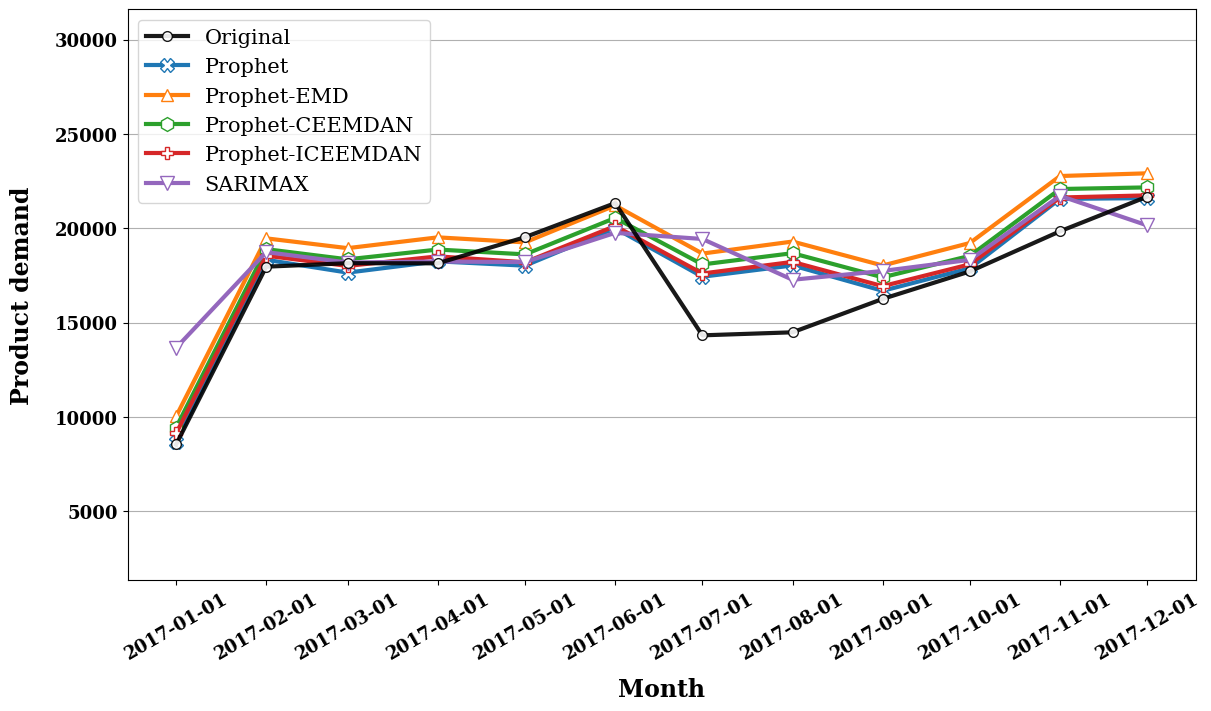

In [ ]:
plotting_test(dmn_df, dmn_df_p, dmn_df_ep, dmn_df_cp, dmn_df_icp, dmn_df_s, "Product demand", "Month", "demand1_test_func.jpg", 12)

## bar plot

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] += ['Times Roman']
width = 0.1

def bar_plotter(values, title, name, tick):
  xticks = ['MAPE']
  multiplier = 0
  x = np.arange(len(xticks))

  fig, ax = plt.subplots(layout="constrained", figsize=(10,6))

  for i,j in values.items():
    offset = width * multiplier
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] += ['Times Roman']
    rects = ax.bar(x + offset, j, width, label = i)
    ax.bar_label(rects, padding=4, fontweight="bold", fontsize=13)
    multiplier+=1

  plt.legend(fontsize=13, loc="upper left")

  ax.set_xticks(x+tick, xticks, fontsize=14, fontweight="bold")
  plt.yticks(fontweight='bold', fontsize=14)

  ceil = round(max(list(values.values())) + 0.2*(max(list(values.values()))))

  plt.ylim(0, ceil)

  plt.grid(axis='y')
  ax.set_axisbelow(True)
  plt.margins(2*(1-len(values)/10), 0)
  plt.savefig(f"{name}.jpg", dpi=1200)

round


In [ ]:
def rounder(dictionary):
  for i,j in dictionary.items():
    dictionary[i] = round(j, 2)
  return(dictionary)

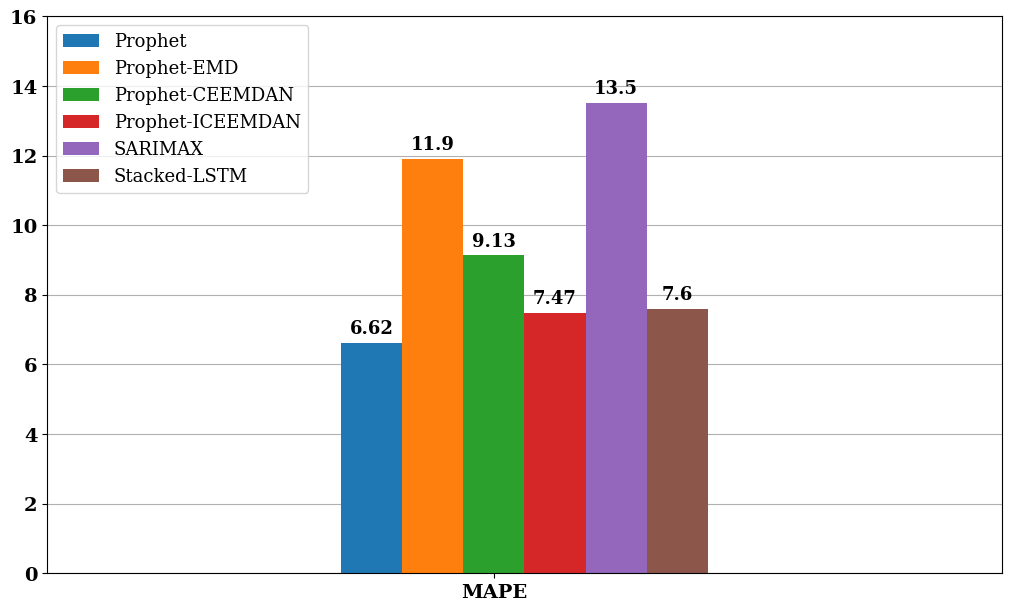

In [ ]:
dmn1_values = {
    "Prophet": (6.62),
    "Prophet-EMD": (11.9),
    "Prophet-CEEMDAN":(9.13),
    "Prophet-ICEEMDAN":(7.47),
    "SARIMAX":(13.5),
    "Stacked-LSTM" : (7.598),
}

bar_plotter(rounder(dmn1_values), "Furniture Product Demand 1", "demand1_comparison_bar",0.3)
